In [86]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import utils
from utils.get_nn_models import *
from utils.sbiutils import *
from utils.torchutils import *
from inference.base import *
import torch
import pickle
import seaborn as sns
from inference.snpe.snpe_c import SNPE_C as SNPE
# from networks.summary_nets import LotkaSummary

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [98]:
def oup(theta, n=50, N=100):
    if len(theta.shape) == 1:
        theta1 = theta[0]
        theta2 = torch.exp(theta[1])
    else:
        theta1 = theta[0, 0]
        theta2 = torch.exp(theta[0, 1])

    # noises
    T, d = 10.0, n+1
    dt = T/d
    Y = torch.zeros([N, n])
    Y[:, 0] = 10
    for i in range(N):
        w = torch.normal(0., 1., size=(n,1))

        for t in range(n-1):
            mu, sigma = theta1*(theta2 - Y[i, t])*dt, 0.5*(dt**0.5)*w[t]
            Y[i, t+1] = Y[i, t] + mu + sigma
    return Y

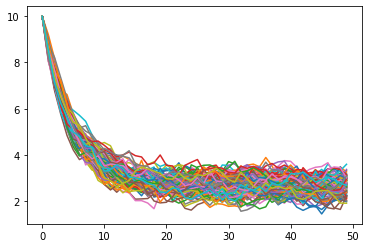

In [88]:
theta = torch.tensor([1, 1])
Y = oup(theta)
for i in range(100):
    plt.plot(range(50), Y[i])

In [94]:
prior = [Uniform(torch.zeros(1), torch.ones(1)),
         Uniform(-2*torch.zeros(1), 2*torch.ones(1))]
simulator, prior = prepare_for_sbi(oup, prior)

num_simulations = 4000

In [99]:
theta, x = simulate_for_sbi(oup, prior, num_simulations=num_simulations)
x = x.reshape(num_simulations, 100, 50).to(device)
theta = theta.to(device)
np.save("data/oup_x_4000.npy", x)
np.save("data/oup_theta_4000.npy", theta)

Running 4000 simulations.:   0%|          | 0/4000 [00:00<?, ?it/s]